In [38]:
import numpy as np
from itertools import combinations
from tqdm.notebook import tqdm
from utils.visualization_animation import louvain_animation


In [39]:

def modularity_matrix(adj_matrix: np.ndarray) -> np.ndarray:
    k_i = np.expand_dims(adj_matrix.sum(axis=1), axis=1)
    k_j = k_i.T
    norm = 1 / k_i.sum()
    K = norm * np.matmul(k_i, k_j)

    return norm * (adj_matrix - K)


In [40]:
def modularity(adj_matrix: np.ndarray, communities: list) -> float:

    k_i = np.expand_dims(adj_matrix.sum(axis=1), axis=1)
    k_j = k_i.T

    weights_sum = k_i.sum()
    
    # if the nodes aren't linked we return the worst modularity
    if weights_sum == 0:
        return -1
    
    norm = 1 / weights_sum
    K = norm * np.matmul(k_i, k_j) # (ki * kj) / 2m
    mod_matrix = norm * (adj_matrix - K)  #  ( 1/2m ) *  Aij - (ki * kj) / 2m


    C = np.zeros_like(mod_matrix)

    for community in communities:
        for i, j in combinations(community, 2):
            C[i, j] = 1.0
            C[j, i] = 1.0

    return np.tril(np.multiply(mod_matrix, C), 0).sum()

In [41]:

def generate_adj_matrix(adj_matrix , V):
    # keep only the nodes in V
    # return adj_matrix[V][:,V]

    new_adj_matrix = adj_matrix.copy()

    for i in range(new_adj_matrix.shape[0]):
        if i not in V:
            new_adj_matrix[i, :] = 0
            new_adj_matrix[:, i] = 0
    
    return new_adj_matrix

In [42]:
def communities_to_frame( n , communities , modularity):

    nodes = list(range(n))

    for i, community in enumerate(communities):
        for node in community:
            nodes[node]  = i+1

    return {'C':nodes , 'Q':modularity}


In [43]:
frames = []

In [44]:
def GCP(adj_matrix: np.ndarray) -> list:
    V = list(range(adj_matrix.shape[0]))
    
    v = np.random.choice(V)
    V.remove(v)
    
    K0 = [v]
    communities = [K0]
    nodes = [v]

    Mdb = -1

    while V:
        v = np.random.choice(V)
        Mdb = -1
        best_community = None
        best_community_index = -1

        

        new_adj_matrix = generate_adj_matrix(
            adj_matrix, nodes + [v])

        for i,Ki in enumerate(communities):
            Ki_new =  Ki + [v] 
            
            new_communities = communities.copy()
      
            new_communities[i] = Ki_new

            Md = modularity( new_adj_matrix, new_communities )

            if Md > Mdb:
                Mdb = Md
                best_community = Ki_new
                best_community_index = i

        #TODO : verify which formula to use
        if len(nodes)>1:
            # new_adj_matrix = generate_adj_matrix(adj_matrix, nodes)
            # Mdphi = modularity(new_adj_matrix, communities)

            new_adj_matrix = generate_adj_matrix(adj_matrix, nodes + [v])
            Mdphi = modularity(new_adj_matrix, communities + [[v]])
    

        else: 
            Mdphi = -1 

        if Mdb > Mdphi :
            communities[best_community_index] = best_community
            # print("Modularity : " , Mdb)
        else:

            Mdb = Mdphi
            # print("Modularity : " , Mdphi)
            Ki = [v]           
            communities.append(Ki) 


        nodes.append(v) 

        

        V.remove(v)
        
    return communities  , Mdb

In [45]:
def destruct(adj_matrix, communities , beta):

    nodes = list(range(adj_matrix.shape[0]))

    removed_nodes = np.random.choice(
        nodes, int(beta * len(nodes)), replace=False)

    filtered_communities = [] 
    for community in communities:

        new_community = [node for node in community if node not in removed_nodes]

        if new_community:
            filtered_communities.append(new_community)
    
    return removed_nodes , filtered_communities

In [46]:

def reconstruct(adj_matrix, communities, removed_nodes):

    # print("removed_nodes : " , removed_nodes)

    nodes = [node for node in list(range(adj_matrix.shape[0])) if node not in removed_nodes]


    Mdb = -1

    for node in removed_nodes:

        # print("Choosing Community for node : " , node)

        Mdb = -1
        best_community = None
        best_community_index = -1

        nodes.append(node)

        new_adj_matrix = generate_adj_matrix(adj_matrix, nodes )

        for i, Ki in enumerate(communities):
            Ki_new = Ki + [node]

            new_communities = communities.copy()
            new_communities[i] = Ki_new
            
            Md = modularity(new_adj_matrix, new_communities)

            if Md > Mdb:
                Mdb = Md
                best_community = Ki_new
                best_community_index = i


        Mdphi = modularity(new_adj_matrix, communities)


        communities[best_community_index] = best_community
        continue 
    
        if Mdb >= Mdphi:
            # print("Modularity : " , Mdb)
            communities[best_community_index] = best_community
            # print("Added to Community : " , best_community_index , " : " , best_community)
        else:
            # print("Modularity : " , Mdphi)
            Ki = [node]
            communities.append(Ki)
            Mdb = Mdphi
            # print("Added to new Community : " , Ki)
    
    return communities  , Mdb



    
    

In [47]:
modularity_trace = []
frames = []

In [48]:
def IG(adj_matrix , nb_iterations = 100 , beta=.4):
    frames.clear()
    # frames.append({'C':[i+1 for i in range(adj_matrix.shape[0]) ] , 'Q':0 })


    modularity_trace.clear()
    print(beta)
    print("GCP :")
    communities , mod = GCP(adj_matrix)

    modularity_trace.append(mod)
    frames.append(communities_to_frame(adj_matrix.shape[0] , communities , mod))


    print("communities : " , communities)
    # modularity_trace

    print("IG :")
    for i in tqdm(range(nb_iterations) , desc= "IG" , total=nb_iterations):

        removed_nodes, filtered_communities = destruct( adj_matrix, communities, beta)
        
        new_communities , mod = reconstruct(adj_matrix, filtered_communities, removed_nodes)

        #TODO : turn it to > instead of >=
        if modularity(adj_matrix , new_communities) >= modularity( adj_matrix , communities):
            communities = new_communities
            modularity_trace.append(mod)
            frames.append(communities_to_frame(adj_matrix.shape[0] , communities , mod))
        

        
    print("communities : " , len(communities))
    return communities

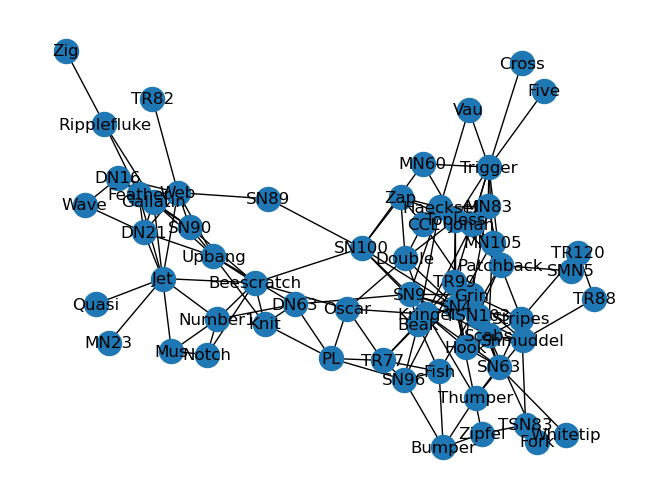

In [49]:
import matplotlib.pyplot as plt
import networkx as nx

file_path = 'data/dolphins.gml'

# Read GML file into a NetworkX graph
G = nx.read_gml(file_path)

nx.draw(G, with_labels=True)
plt.show()

In [50]:
adj_matrix = nx.to_numpy_array(G)
adj_matrix.shape

(62, 62)

In [51]:
communities = IG(adj_matrix , 10, beta=.7)

0.7
GCP :
communities :  [[19, 30, 7], [60, 32], [27, 25, 1, 17, 26], [38, 43, 20, 8, 3, 28, 46, 49, 47, 58, 44], [41, 57, 9, 6, 54, 48, 5, 39, 13], [15, 18, 45, 21, 37, 50, 34, 40, 52, 33, 16, 23, 36, 55, 24, 14, 59, 29, 51], [61, 2, 53, 10, 0, 42], [11], [31], [12], [56], [4], [22], [35]]
IG :


IG:   0%|          | 0/10 [00:00<?, ?it/s]

communities :  5


[{'C': [7, 3, 7, 4, 12, 5, 5, 1, 4, 5, 7, 8, 10, 5, 6, 6, 6, 3, 6, 1, 4, 6, 13, 6, 6, 3, 3, 3, 4, 6, 1, 9, 2, 6, 6, 14, 6, 6, 4, 5, 6, 5, 7, 4, 4, 6, 4, 4, 5, 4, 6, 6, 6, 7, 5, 6, 11, 5, 4, 6, 2, 7], 'Q': 0.20592539852062816}, {'C': [6, 2, 6, 1, 7, 4, 4, 3, 1, 4, 6, 5, 5, 4, 5, 6, 5, 2, 5, 3, 1, 5, 8, 5, 5, 2, 2, 2, 1, 5, 3, 2, 1, 5, 5, 5, 2, 5, 1, 4, 6, 4, 6, 3, 1, 5, 3, 3, 4, 3, 5, 5, 5, 3, 4, 5, 4, 4, 1, 1, 1, 5], 'Q': 0.20925794074601484}, {'C': [5, 2, 5, 1, 4, 3, 3, 2, 4, 3, 5, 4, 4, 3, 1, 4, 1, 1, 4, 2, 1, 4, 1, 4, 4, 1, 1, 1, 2, 4, 2, 1, 3, 4, 1, 4, 4, 4, 1, 3, 4, 3, 5, 1, 1, 4, 2, 2, 3, 2, 1, 4, 1, 1, 3, 4, 3, 3, 1, 4, 1, 5], 'Q': 0.21074126814603852}]


MovieWriter ffmpeg unavailable; using Pillow instead.
c:\Users\ASUS ROG\OneDrive\Desktop\ESI\Current\S2\Projet\Iterative-Greedy\Iterative-Greedy\utils\visualization_animation.py:291: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)


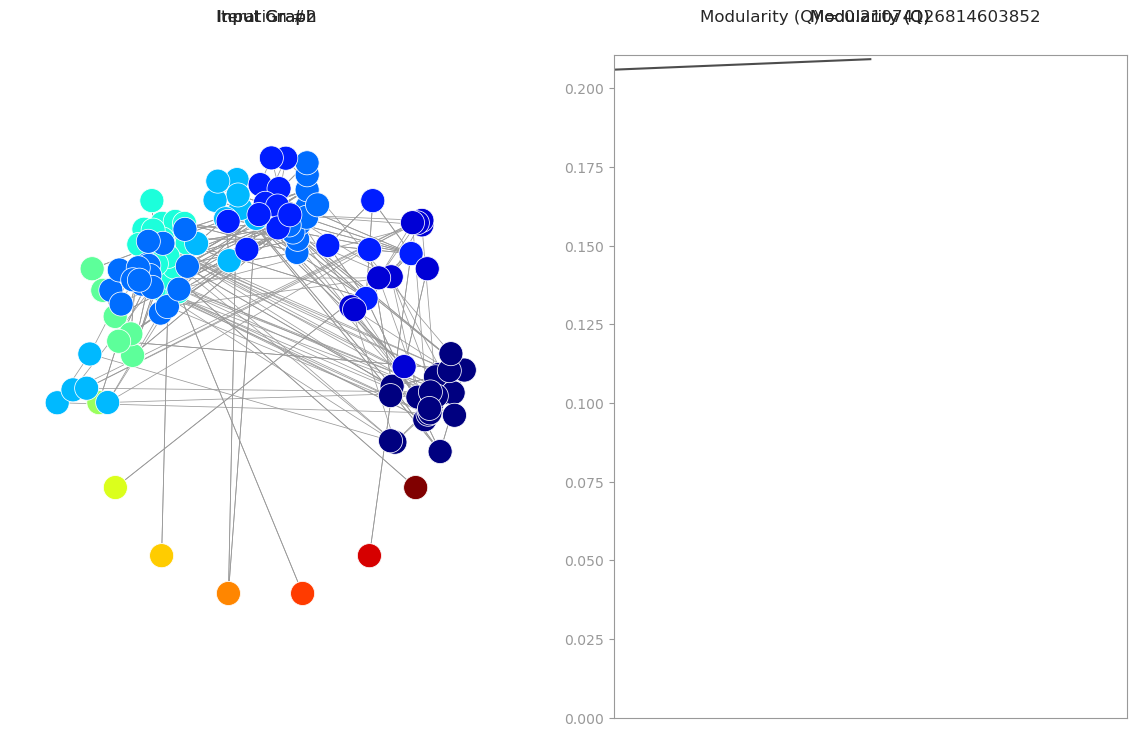

In [53]:
louvain_animation(adj_matrix, frames, dark=False ,duration=60, filename="IG.gif" ,dpi = 200 )